<a href="https://colab.research.google.com/github/jajsmith/npi-topics/blob/master/npi_context_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPI-Context: Using intervention context to inform literature search with case study

1. We make it easier to conduct literature search for new interventions in specific environments by incorporating the context for each intervention in our search.

2. We demonstrate this method on a newly constructed dataset of Canadian NPIs (and Korean/Oxford if we have time)

3. Explain how this can scale. Lead to rapid design, execution, and assessment of interventions.

## Introduction

The competition named "the COVID-19 Open Research Dataset (CORD-19)"  has been launched to support experts in the healthcare domain quickly and accurately receive answers to their scientific questions related to coronaviruses. In the era of AI, an efficient way to achieve such a goal is that AI researchers take advantage of advanced NLP and ML tools to develop an AI-based questioning answering system with information related to COVID-19.  To do so, a dataset named CORD-19 has been freely available to be examined by text mining tools.  The CORD-19 encompasses 40,000 articles about coronaviruses.
For the competition, 10 tasks have been proposed. Each task covers some fundamental questions related to COVID 19.
In this submission, we present our preliminary steps for the development of an AI-based QA system that covers questions related to nonpharmaceutical intervention for COVID-19.

## Method

### Searching the CORD-19 Dataset

We make use of the [covidex.io](https://covidex.io) project using the Anserini information retrieval toolkit via pyserini. All the documents in CORD-19 are indexed in Lucene. We use the demonstration notebook found [here](https://colab.research.google.com/drive/1mrapJp6-RIB-3u6FaJVa4WEwFdEBOcTe) to setup the lucene index and search functionality.

### Building a Dataset of Intervention Events

Policy makers and researchers around the world use literature review to help each team, organization, and country understand the effectiveness of non-pharmaceutical interventions and barriers to compliance *for their specific circumstances*. Observing the leading countries in COVID-19 response like South Korea and China we see drastically different methods used to intervene. **Making use of country-specific context is an important part of improving search quality.**

In order to show the effectivenss of this it is important to have an up-to-date and thorough picture of each countries current interventions and how they are being implemented. One has been created for Canada to use as a case study.

The [howsmyflattening.ca](https://howsmyflattening.ca) team has compiled a dataset of non-pharmaceutical interventions in Canada with 60 intervention labels, 1838 events, and XXX unique information sources. Some of the authors of this notebook are contributors to the Canadian non-pharmaceutical interventions dataset. The dataset can be retrieved on Kaggle [here](https://www.kaggle.com/howsmyflattening/covid19-challenges#npi_canada.csv).

### Intervention Context using Topic Modeling

We use Latent Dirichlet Allocation [(Blei, et. al., 2003)](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) to find topics in the full text announcements recorded for all recorded interventions in the input dataset. We then use keywords from these topics to guide search of relevant documents, comparing and augmenting the search results of the labeled interventions themselves. **Crucially, we are not just modeling topics in existing research, but also in actual interventions to understand the relationships between them.**


## Case Study: Canada

TODO: Add summary of results from below here?

# Setup

In [0]:
from IPython.core.display import display, HTML

In [0]:
%%capture
!pip install pyserini==0.8.1.0
!pip install transformers
!pip install geopandas
!pip install pyLDAvis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import json
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from IPython.html.widgets import interactive
from ipywidgets import interact, interact_manual
from ipywidgets import Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider

from matplotlib import cm
import seaborn as sns
import matplotlib.patches as mpatches
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import AxesGrid
import geopandas as gpd

/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from pyserini.search import pysearch


Let's grab the pre-built index:

In [0]:
%%capture
!wget https://www.dropbox.com/s/d6v9fensyi7q3gb/lucene-index-covid-2020-04-03.tar.gz
!tar xvfz lucene-index-covid-2020-04-03.tar.gz

Sanity check of index size (should be 1.5G):

In [0]:
!du -h lucene-index-covid-2020-04-03

1.5G	lucene-index-covid-2020-04-03


Let's load BioBERT (https://arxiv.org/abs/1901.08746) from HuggingFace Transformers

In [0]:
import torch
import numpy
from tqdm import tqdm
from transformers import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
#tokenizer = AutoTokenizer.from_pretrained('monologg/biobert_v1.1_pubmed', do_lower_case=False)
#model = AutoModel.from_pretrained('monologg/biobert_v1.1_pubmed')

# Canadian non-pharmaceutical interventions Dataset

The Canadian non-pharmaceutical interventions dataset covers compiled information from **January 1st to March 31st, 2020** across 13 provinces and territories as well as the largest 20 CMAs in Canada.
The 60 types of intervention contained in this dataset includes (but not restricted to) government announcements, initiatives, and orders, such as  social distancing measures or social and fiscal measures. The rest of the notebook will use this as the reference dataset for creating visualization and topic modelling.

### Dataset retrieval

Now let's grab the Canadian NPI dataset.

In [0]:
!wget https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_full.csv

--2020-04-16 21:50:42--  https://raw.githubusercontent.com/jajsmith/COVID19NonPharmaceuticalInterventions/master/npi_full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6273359 (6.0M) [text/plain]
Saving to: ‘npi_full.csv’

npi_full.csv        100%[===================>]   5.98M  --.-KB/s    in 0.1s    

2020-04-16 21:50:42 (52.3 MB/s) - ‘npi_full.csv’ saved [6273359/6273359]



In [0]:
full_df = pd.read_csv('npi_full.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'])
full_df['end_date'] = pd.to_datetime(full_df['end_date'])
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)

In order to aid efforts to fight the pandemic, we aim to use a standard metric for analyzing the governments responses. The Oxford COVID-19 Government Response Tracker (OxCGRT) has collected the Coronavirus Government Response Tracker Dataset. The dataset is collected and updated in real time by a team of dozens of students and staff at Oxford University. This Dataset is available at this [link](https://www.bsg.ox.ac.uk/research/research-projects/coronavirus-government-response-tracker).
 They have provided 13 indicators of such responses. 9 of these metrics (S1-S7, S12, and S13) are non-financial policies such as event cancelation and the others (S8-S11) are financial indicators such as monetary measures. The Canadian NPI dataset linked all eligible interventions type to one of the Oxford categories. 
 A list of these indicators

Each indicator contains a range of values. For more information on the list of the indicators and the encodings visit the [Encodings](https://www.bsg.ox.ac.uk/sites/default/files/2020-04/BSG-WP-2020-031-v4.0_0.pdf).
Averaging the stringency numbers gives a composite index and allows us to understand how quickly and strinctly different areas of Canada reacted to COVID-19 over time. The Stringency Index is calculated using only the policy indicators S1 – S7. This metric is calculated by averaging the normalized values from each indicator. Further details on calculation of this index is provided at: [Calculation details](bsg.ox.ac.uk/sites/default/files/Calculation%20and%20presentation%20of%20the%20Stringency%20Index.pdf)

Note that this index simply records the number and strictness of government policies and should not be interpreted as ‘scoring’ the appropriateness or effectiveness of a country’s response.


The following map summerizes the intervention policies taken in each county. 
Selecting an intervention type and a specific day from Jan 1st 2020 to April 2020 would show the level of government response on the map. moving the pointer on each country would show the number of positive cases and intervention level.

In [0]:
%%html
<div class='tableauPlaceholder' id='viz1587056618048' style='position: relative'><noscript><a href='https:&#47;&#47;www.bsg.ox.ac.uk&#47;research&#47;publications&#47;variation-government-responses-covid-19'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ox&#47;Oxford-COVID-19&#47;Geo&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Oxford-COVID-19&#47;Geo' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ox&#47;Oxford-COVID-19&#47;Geo&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1587056618048');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='90%';vizElement.style.height=(divElement.offsetWidth*0.55)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Interactive Visualization Setup

In [0]:
!wget https://flatteningthecurve.herokuapp.com/data/covid

--2020-04-16 21:50:43--  https://flatteningthecurve.herokuapp.com/data/covid
Resolving flatteningthecurve.herokuapp.com (flatteningthecurve.herokuapp.com)... 34.199.226.42, 52.5.140.196, 52.71.209.91, ...
Connecting to flatteningthecurve.herokuapp.com (flatteningthecurve.herokuapp.com)|34.199.226.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2606120 (2.5M) [text/csv]
Saving to: ‘covid’

covid               100%[===================>]   2.49M  --.-KB/s    in 0.09s   

2020-04-16 21:50:44 (27.1 MB/s) - ‘covid’ saved [2606120/2606120]



In [0]:
full_cases = pd.read_csv('covid')

In [0]:
# List of the Oxford intervention categories
intervention_categories = ['S1 School Closing',
                           'S2 Workplace closing',
                           'S3 Cancel public events',
                           'S4 Close public transport',
                           'S5 Public info campaigns',
                           'S6 Restrictions on internal movements',
                           'S7 International travel controls',
                           'S8 Fiscal measures',
                           'S9 Monetary measures (interest rate)',
                           'S10 Emergency investment in health care',
                           'S11 Investment in vaccines',
                           'S12 Testing policy',
                           'S13 Contact tracing']

In [0]:
# This parses the values related to the intervention category S9
def parse_rate(string):
    if type(string) == float:
        return string
    cad = string[:-1]
    return float(cad)

def impute_intervention(prov):
    for interv_cat in intervention_categories:
        prov[interv_cat] = 0
    closure_geo = ['S1', 'S2', 'S3', 'S4', 'S6']
    public_geo = ['S5']
    travel = ['S7']
    rate = ['S9']
    fiscal = ['S8', 'S10', 'S11']
    test = ['S12']
    trace = ['S13']
    for idx, row in prov.iterrows():
        interv = row['oxford_government_response_category']
        if interv in intervention_categories:
            interv_prefix = str(interv).split(' ')[0]
            subset = prov.iloc[:idx+1]
            subset = subset[subset['oxford_government_response_category'] == interv]
            if interv_prefix in closure_geo:
                prov.at[idx, interv] = (np.nanmax(subset['oxford_closure_code']) + np.nanmax(subset['oxford_geographic_target_code'])) * 100 / 3
            elif interv_prefix in public_geo:
                prov.at[idx, interv] = (np.nanmax(subset['oxford_geographic_target_code']) + np.nanmax(subset['oxford_public_info_code'])) * 100 / 2
            elif interv_prefix in travel:
                prov.at[idx, interv] = (subset['oxford_travel_code'].max()) * 100 / 3
            elif interv_prefix in rate:
                prov.at[idx, interv] = subset['oxford_monetary_measure'].apply(parse_rate).sum()
            elif interv_prefix in fiscal:
                prov.at[idx, interv] = pd.to_numeric(subset['oxford_fiscal_measure_cad']).sum()
            elif interv in test:
                prov.at[idx, interv] = subset['oxford_testing_code'].max() * 100 / 2
            elif interv in trace:
                prov.at[idx, interv] = subset['oxford_tracing_code'].max() * 100 / 2
            if idx > 0:
                for i in intervention_categories:
                    if i != interv:
                        prov.at[idx, i] = prov.at[idx-1, i]
        else:
            if idx > 0:
                for i in intervention_categories:
                    prov.at[idx, i] = prov.at[idx-1, i]
    return prov

In [0]:
def construct_positive(prov):
    prov['Cumulative Cases'] = 0
    for idx, row in prov.iterrows():
        if idx == 0:
            prov.at[0, 'Cumulative Cases'] = prov.iloc[0]['Daily Cases']
        else:
            prov.at[idx, 'Cumulative Cases'] = prov.iloc[idx-1]['Cumulative Cases'] + prov.iloc[idx]['Daily Cases']
    
    return prov

In [0]:
def generate_cases_province(full_npi, pn, pn_short):
    prov = full_npi[(full_npi['region'] == pn)]
       
    prov = prov[['start_date', 'region', 'end_date', 'oxford_government_response_category', 'oxford_closure_code',
       'oxford_public_info_code', 'oxford_travel_code',
       'oxford_geographic_target_code', 'oxford_fiscal_measure_cad',
       'oxford_monetary_measure', 'oxford_testing_code', 'oxford_tracing_code']]
    
    prov['start_date'] =  pd.to_datetime(prov['start_date'], infer_datetime_format='%m/%d/%Y')
    
    cs = full_cases[full_cases['province'] == pn_short]
    cs['start_date'] = pd.to_datetime(cs['date'], format='%Y-%m-%d')
    cs = cs.groupby('start_date')['id'].agg('count').reset_index().rename(columns={'id': 'Daily Cases'})
    cs = construct_positive(cs)
    prov = pd.merge(prov, cs, on='start_date', how='outer')
    prov = prov.sort_values(by='start_date',ascending=True).reset_index(drop=True)
    
    prov = impute_intervention(prov)
    prov = prov.drop_duplicates(subset ="start_date", 
                     keep = 'last').reset_index(drop=True) 
    
    
    return prov

In [0]:
full_viz = full_df.copy()
full_viz['oxford_geographic_target_code'].fillna(0, inplace=True)
full_viz['oxford_closure_code'].fillna(0, inplace=True)
full_viz['oxford_public_info_code'].fillna(0, inplace=True)

In [0]:
on = generate_cases_province(full_viz, 'Ontario', 'Ontario')
qb = generate_cases_province(full_viz, 'Quebec', 'Quebec')
bc = generate_cases_province(full_viz, 'British Columbia', 'BC')
sk = generate_cases_province(full_viz, 'Saskatchewan', 'Saskatchewan')
nb = generate_cases_province(full_viz, 'New Brunswick', 'New Brunswick')
ns = generate_cases_province(full_viz, 'Nova Scotia', 'Nova Scotia')
mb = generate_cases_province(full_viz, 'Manitoba', 'Manitoba')
ab = generate_cases_province(full_viz, 'Alberta', 'Alberta')
pei = generate_cases_province(full_viz, 'Prince Edward Island', 'PEI')
nwt = generate_cases_province(full_viz, 'Northwest Territories', 'NWT')
nl = generate_cases_province(full_viz, 'Newfoundland and Labrador', 'NL')
yt = generate_cases_province(full_viz, 'Yukon', 'Yukon')
nv = generate_cases_province(full_viz, 'Nunavut', 'Nunavut')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [0]:
prov_dict = {'Ontario': on,
             'Quebec': qb,
             'British Columbia': bc,
             'Saskatchewan': sk,
             'New Brunswick': nb,
             'Nova Scotia': ns,
             'Manitoba' : mb,
             'Alberta' : ab,
             'Prince Edward Island': pei,
             'Northwest Territories' : nwt,
             'Newfoundland and Labrador' : nl,
             'Yukon': yt,
             'Nunavut': nv}
prov_list = ['Ontario', 'Quebec', 'British Columbia', 'Saskatchewan', 
             'New Brunswick', 'Nova Scotia', 'Manitoba', 'Alberta',
             'Prince Edward Island', 'Northwest Territories', 'Newfoundland and Labrador', 'Yukon', 'Nunavut']

In [0]:
w_prov1 = widgets.Select(description="Province 1", options=prov_list)
w_prov2 = widgets.Select(description="Province 2", options=prov_list)
w_intervention_multi = widgets.SelectMultiple(description="Different intervention types",
                                             options=intervention_categories)
w_stats = widgets.Select(description="Different COVID-19 indicators",
                         options=['Daily Cases', 'Cumulative Cases'])
w_stringency = widgets.Select(description="Stringency Index", options=[1, 33, 50, 66, 100])

In [0]:
def compare_provinces_cases(prov1_str, prov2_str, interv_type, stat, stringency_idx):
    prov1 = prov_dict[prov1_str]
    prov2 = prov_dict[prov2_str]
    
    if stat == "Daily Cases":
        height = 50
    else:
        height = 500
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15, 10))
    colors = sns.color_palette("Set2", n_colors=8)
    legend_labels = [mpatches.Patch(color=colors[0], label=stat)]
    
    begin_date = np.datetime64('2020-02-15')
    
    if prov1['start_date'].values[-1] > prov2['start_date'].values[-1]:
        end_date = prov2['start_date'].values[-1]
    else:
        end_date = prov1['start_date'].values[-1]
        
    ax1.set_xlim(left=begin_date, right=end_date)
    
    ax1.bar(prov1['start_date'], prov1[stat], color=colors[0])
    ax1.set(ylabel=stat, title=prov1_str)
    
    ax2.bar(prov2['start_date'], prov2[stat], color=colors[0])
    ax2.set(xlabel = 'Date', ylabel=stat, title=prov2_str)
    
    for idx in range(len(interv_type)):
        if len(prov1[prov1[interv_type[idx]] >= stringency_idx]['start_date']) :
            first_date_1 = prov1[prov1[interv_type[idx]] >= stringency_idx]['start_date'].values[0]
            second_date_1 = first_date_1 + np.timedelta64(14,'D')
            
            ax1.axvline(x=first_date_1, linestyle='-', color=colors[1+idx])
            ax1.text(first_date_1+ np.timedelta64(8, 'h'), height, interv_type[idx],rotation=90)
            ax1.axvspan(second_date_1, end_date, facecolor= colors[1+idx], alpha=0.4)
            ax1.text(second_date_1+ np.timedelta64(8, 'h'), height,
                    interv_type[idx].split(' ')[0] + ' - after 14 days',rotation=90)
        
        if len(prov2[prov2[interv_type[idx]] >= stringency_idx]['start_date']) :
            first_date_2 = prov2[prov2[interv_type[idx]] >= stringency_idx]['start_date'].values[0]
            second_date_2 = first_date_2 + np.timedelta64(14,'D')
            
            ax2.axvline(x=first_date_2, linestyle='-', color=colors[1+idx])
            ax2.text(first_date_2+ np.timedelta64(8, 'h'),height, interv_type[idx],rotation=90)
            
            ax2.axvspan(second_date_2, end_date, facecolor= colors[1+idx], alpha=0.4)
            ax2.text(second_date_2+ np.timedelta64(8, 'h'), height,
                    interv_type[idx].split(' ')[0] + ' - after 14 days',rotation=90)
        
    
        legend_labels.append(mpatches.Patch(color=colors[1+idx], label=interv_type[idx]))  

    ax1.legend(handles=legend_labels, loc=2)
    ax2.legend(handles=legend_labels, loc=2)
    
    plt.show()

In [0]:
def view_case_provinces(p1, p2, i, nb, s):
    display(compare_provinces_cases(p1, p2, i, nb, s))

### Interactive Interventions and Case Data

In [0]:
interactive(view_case_provinces, p1=w_prov1, p2=w_prov2, i=w_intervention_multi,
            nb=w_stats, s=w_stringency)

interactive(children=(Select(description='Province 1', options=('Ontario', 'Quebec', 'British Columbia', 'Sask…

### Intervention Impact on Mobility Explorer

In [0]:
%%html
<div class='tableauPlaceholder' id='viz1586995220180' style='position: relative'  ><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;On&#47;OntarioInterventions&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='OntarioInterventions&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;On&#47;OntarioInterventions&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1586995220180');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='80%';vizElement.style.height=(divElement.offsetWidth*0.37)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>


### Intervention Stringency by Geography

In [0]:
%%html
<div class='tableauPlaceholder' id='viz1587010458723' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;FM&#47;FMXT99WQW&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;FMXT99WQW' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;FM&#47;FMXT99WQW&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1587010458723');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='90%';vizElement.style.height=(divElement.offsetWidth*0.55)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Retrieving Research from Expert NPI Labels

These are the labels used in the Canadian NPI dataset. It can be expected that they would provide a strong baseline for search results that can inform the Canadian response to COVID-19.

In [0]:
full_df['oxford_government_response_category'].astype(str).unique()

array(['S12 Testing policy', 'nan', 'S3 Cancel public events',
       'S5 Public info campaigns', 'S7 International travel controls',
       'S1 School Closing', 'S10 Emergency investment in health care',
       'S8 Fiscal measures', 'S6 Restrictions on internal movements',
       'S13 Contact tracing', 'S2 Workplace closing',
       'S4 Close public transport',
       'S9 Monetary measures (interest rate)',
       'S11 Investment in vaccines'], dtype=object)

In [0]:
searcher = pysearch.SimpleSearcher('lucene-index-covid-2020-04-03/')

def search(search_strings, topk=5):
  columns = ['search', 'rank', 'title', 'score']
  results_df = pd.DataFrame()
  for search in search_strings:
    hits = searcher.search(search)
    label_hits.append(hits)
    print("")
    print("Search term: ", search)
    print("  hits:", len(hits))
    scores = [h.score for h in hits]
    print("  mean score:", np.mean(scores))
    print("")
    for i in range(0, min(topk, len(hits))):
      print(f'{i+1:2} {hits[i].docid} {hits[i].score:.5f} {hits[i].lucene_document.get("title")} {hits[i].lucene_document.get("doi")}')
      row_df = pd.DataFrame([[search, i+1, hits[i].lucene_document.get("title"), hits[i].score]], columns=columns)
      results_df = results_df.append(row_df)

  return results_df

In [0]:
results_df = search(full_df['oxford_government_response_category'].astype(str).unique())


Search term:  S12 Testing policy
  hits: 10
  mean score: 4.875879955291748

 1 r35mx62u 6.97440 Polycistronic (tri- or bicistronic) phytoreoviral segments translatable in both plant and insect cells. 
 2 cwcpsq65 6.86810 Rice dwarf phytoreovirus segment S12 transcript is tricistronic in Vitro 10.1016/0042-6822(92)90279-x
 3 mix6j9jd 4.54680 Examining the policies and guidelines around the use of masks and respirators by healthcare workers in China, Pakistan and Vietnam 10.1177/1757177414560251
 4 vf3lwf66 4.44630 An analytic framework to develop policies for testing, prevention, and treatment of two-stage contagious diseases 10.1007/s10479-012-1103-8
 5 kk9tqz4j 4.39350 Unconsented HIV Testing in Cases of Occupational Exposure: Ethics, Law, and Policy 10.1111/j.1553-2712.2012.01453.x

Search term:  nan
  hits: 9
  mean score: 4.483555575211843

 1 hfzygxjj 7.90610 De-O-Acetylation of mucin-derived sialic acids by recombinant NanS-p esterases of Escherichia coli O157:H7 strain EDL933 

In [0]:
results_df

,search,rank,title,score
0,S12 Testing policy,1,Polycistronic (tri- or bicistronic) phytoreovi...,6.9744
0,S12 Testing policy,2,Rice dwarf phytoreovirus segment S12 transcrip...,6.8681
0,S12 Testing policy,3,Examining the policies and guidelines around t...,4.5468
0,S12 Testing policy,4,An analytic framework to develop policies for ...,4.4463
0,S12 Testing policy,5,Unconsented HIV Testing in Cases of Occupation...,4.3935
...,...,...,...,...
0,S11 Investment in vaccines,1,Illuminating the Sites of Enterovirus Replicat...,7.9934
0,S11 Investment in vaccines,2,Investments in respiratory infectious disease ...,5.5977
0,S11 Investment in vaccines,3,Vaccines of the future,5.0396
0,S11 Investment in vaccines,4,Perspectives on advancing preventative medicin...,5.0321


# Keyword Selection from LDA Topics on Canadian NPI Full Text (gensim)

The topic modeling algorithm that we have utilized in this approach is one well-known generative probabilistic model that is referred to as **Latent Dirichlet Allocation (LDA)**

LDA receives words as an input vector and generates topics which are probability distribution over words based on a generative process. LDA uses a joint probability distribution over both the observed and hidden random variables and compute the posterior distribution (conditional distribution) of the hidden variables given the observed variables. **The fundamental assumption of LDA is that documents can be assigned to multiple topics**. Another assumption is that topics are hidden variables, and words in documents are visible variables. Thus, LDA performs a generative process by receiving words (*apparent variables*) as an input vector to provide topics (*hidden variables*) which are **probability distribution over words**


## Import Packages
The main package that we have used are *gensim*, *nltk* and *pandas*

In [0]:
import os
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pandas
import re
import pandas
from pprint import pprint

2020-04-16 21:50:50,283 : INFO : 'pattern' package not found; tag filters are not available for English


## Read Data and Preprocessing
In this step we read the dataset and select the titles 

In [0]:
engl_df = full_df[full_df['region'] != 'Quebec']
full_text = engl_df['source_full_text'].drop_duplicates().astype(str)
data = full_text.values
data = [re.sub('\s+', ' ', text) for text in data] # remove new lines
data = [re.sub("\'", "", text) for text in data] # remove quotes
print("Total number of documents: ", len(data))

Total number of documents:  915


In [0]:
words = [row.split() for row in data]

print(words[13:14])



[['Northwest', 'Territories', 'COVID-19', 'Economic', 'Relief', 'Yellowknife', '—', 'March', '20,', '2020News', 'Releases', 'The', 'Government', 'of', 'the', 'Northwest', 'Territories', '(GNWT)', 'recognizes', 'the', 'difficulties', 'that', 'the', 'COVID-19', 'pandemic', 'and', 'health', 'measures', 'being', 'taken', 'to', 'combat', 'the', 'virus’', 'spread', 'is', 'causing', 'NWT', 'businesses,', 'service', 'providers,', 'residents,', 'governments', 'and', 'non-government', 'organizations.', 'Today,', 'Minister', 'Caroline', 'Wawzonek,', 'Minister', 'of', 'Finance', 'and', 'Minister', 'Katrina', 'Nokleby,', 'Minister', 'of', 'Industry,', 'Tourism', 'and', 'Investment,', 'and', 'Infrastructure,', 'announced', 'Economic', 'Relief', 'Measures', 'that', 'will', 'help', 'minimize', 'expenses', 'and', 'keep', 'cash', 'available', 'for', 'immediate', 'needs', 'in', 'this', 'time', 'of', 'uncertainty.', 'The', 'GNWT', 'has', 'put', 'together', 'an', 'initial', 'economic', 'relief', 'package',

 ## Bigram and Trigram 
We need to provide Bigram and Trigram from the orginal texts. 

In [0]:

bigram = Phrases(words, min_count=30, progress_per=10000)
trigram = Phrases(bigram[words], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

bigrams = [b for l in data for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]


2020-04-16 21:50:50,536 : INFO : collecting all words and their counts
2020-04-16 21:50:50,538 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-04-16 21:50:51,233 : INFO : collected 156366 word types from a corpus of 374774 words (unigram + bigrams) and 915 sentences
2020-04-16 21:50:51,234 : INFO : using 156366 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2020-04-16 21:50:51,244 : INFO : collecting all words and their counts
2020-04-16 21:50:51,251 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-04-16 21:50:53,363 : INFO : collected 161499 word types from a corpus of 352144 words (unigram + bigrams) and 915 sentences
2020-04-16 21:50:53,364 : IN


## NLTK Stop words

In [0]:

stop_words = stopwords.words('english')
#stop_words.extend(['school', 'Nonpharmaceutical Interventions', 'education'])


In [0]:
r = [x.split() for x in full_df['region'].dropna().unique().tolist()]
r = np.hstack([np.array(x) for x in r])
sr = [x.split() for x in full_df['subregion'].dropna().unique().tolist()]
sr = np.hstack([np.array(x) for x in sr])
geo_stop_words = np.append(r, sr)
geo_stop_words = [x.lower() for x in geo_stop_words]
geo_stop_words = [x.replace('(','').replace(')','') for x in geo_stop_words]


In [0]:
stop_words.extend(geo_stop_words)


In [0]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

words_nostops = remove_stopwords(words)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
words_bigrams = make_bigrams(words_nostops)

## Create the Dictionary and Corpus needed for Topic Modeling
The LDA function receives *Dictionary* and *Corpus* as inpuut and provides *Topics* as output


We creat dictionary using *corpora.Dictionary*

In [0]:
id2word = corpora.Dictionary(words_bigrams)



2020-04-16 21:50:58,308 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-16 21:50:58,522 : INFO : built Dictionary(10438 unique tokens: ['acquiring', 'act', 'actions', 'adults', 'advice']...) from 915 documents (total 211279 corpus positions)


## Building the Topic Model
To train the LDA model, we need to define 1) the corpus, 2) dictionary and 3)the number of topics. We also need to determine the values of hyperparameters such as *alpha* and *eta*. The defult values of these parametters are $1/#topic$. Another parameter is *chunksize* that determines the number of documents to be used in each training chunk. Finally *passes* is the total number of training passes. 


In [0]:
texts = words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=35, 
                                       random_state=10,
                                       chunksize=100,
                                       passes=1,
                                       per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

2020-04-16 21:50:58,710 : INFO : using symmetric alpha at 0.02857142857142857
2020-04-16 21:50:58,711 : INFO : using symmetric eta at 0.02857142857142857
2020-04-16 21:50:58,717 : INFO : using serial LDA version on this node
2020-04-16 21:50:58,779 : INFO : running online (single-pass) LDA training, 35 topics, 1 passes over the supplied corpus of 915 documents, updating model once every 100 documents, evaluating perplexity every 915 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-16 21:50:58,780 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-04-16 21:50:58,782 : INFO : PROGRESS: pass 0, at document #100/915
2020-04-16 21:50:59,012 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:50:59,104 : INFO : topic #0 (0.029): 0.025*"canada" + 0.018*"covid" + 0.011*"government" + 0.010*"health" + 0.009*"march" + 0.008*"canadians" + 0.007*"order

[(34,
  '0.040*"bc" + 0.026*"pei" + 0.021*"covid" + 0.019*"health" + 0.014*"female" '
  '+ 0.011*"officer" + 0.011*"province" + 0.010*"sk" + 0.010*"march" + '
  '0.010*"www"'),
 (15,
  '0.032*"covid" + 0.019*"self" + 0.017*"ca" + 0.013*"information" + '
  '0.011*"essential" + 0.011*"www" + 0.010*"health" + 0.010*"visit" + '
  '0.009*"social_distancing" + 0.009*"individuals"'),
 (32,
  '0.043*"parking" + 0.040*"discontinue" + 0.029*"residential" + '
  '0.020*"permit" + 0.014*"enforced" + 0.014*"street" + 0.013*"effect" + '
  '0.013*"developments" + 0.012*"traffic" + 0.012*"route"'),
 (18,
  '0.099*"publichealth" + 0.057*"viruses" + 0.044*"misinformation" + '
  '0.032*"toll" + 0.024*"clinical" + 0.021*"cold" + 0.017*"world" + '
  '0.017*"cause" + 0.016*"chief" + 0.016*"organization"'),
 (6,
  '0.032*"workers" + 0.021*"said" + 0.021*"order" + 0.019*"health_care" + '
  '0.017*"health" + 0.017*"protection" + 0.016*"orders" + 0.015*"act" + '
  '0.014*"public_health" + 0.013*"emergency"'),
 (

In [0]:
Perplexity = lda_model.log_perplexity(corpus)
print ("Perplexity:", Perplexity)

2020-04-16 21:51:04,023 : INFO : -8.387 per-word bound, 334.7 perplexity estimate based on a held-out corpus of 915 documents with 211279 words


Perplexity: -8.386606035240986



# Compute Coherence Score
A good LDA model can provide coherent topics. So its topic coherence is high. 

In [0]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2020-04-16 21:51:04,063 : INFO : using WordOccurrenceAccumulator to estimate probabilities from sliding windows
2020-04-16 21:51:04,158 : INFO : WordOccurrenceAccumulator accumulated stats from 1000 documents
2020-04-16 21:51:04,245 : INFO : WordOccurrenceAccumulator accumulated stats from 2000 documents
2020-04-16 21:51:04,314 : INFO : WordOccurrenceAccumulator accumulated stats from 3000 documents
2020-04-16 21:51:04,392 : INFO : WordOccurrenceAccumulator accumulated stats from 4000 documents
2020-04-16 21:51:04,466 : INFO : WordOccurrenceAccumulator accumulated stats from 5000 documents
2020-04-16 21:51:04,543 : INFO : WordOccurrenceAccumulator accumulated stats from 6000 documents
2020-04-16 21:51:04,624 : INFO : WordOccurrenceAccumulator accumulated stats from 7000 documents
2020-04-16 21:51:04,693 : INFO : WordOccurrenceAccumulator accumulated stats from 8000 documents
2020-04-16 21:51:04,755 : INFO : WordOccurrenceAccumulator accumulated stats from 9000 documents
2020-04-16 21:5


Coherence Score:  0.3927473266568561


## What is an optimal LDA model ? 
How can we find the best values of Hyperparameters such as number of topics ( Model Hyperparameters) and alpha and beta that are reffered to as Document-Topic Density and and Word-Topic Density, respectivly and known as "Dirichlet hyperparameters". 

### 1. The number of Topics 

In [0]:
start=1
limit=50
step=2
coherence_values = []
model_list = []
for num_topics in range(start, limit, step):
    print('Topics: ', num_topics)
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=10,
                                       chunksize=100,
                                       passes=4,
                                       per_word_topics=True)
    model_list.append(lda_model)
    coherence_model_lda_c_v = CoherenceModel(model=lda_model, texts=words_bigrams, corpus=corpus, dictionary=id2word, coherence="c_v")
    coherence_values.append(coherence_model_lda_c_v.get_coherence())




2020-04-16 21:51:19,971 : INFO : using symmetric alpha at 1.0
2020-04-16 21:51:19,972 : INFO : using symmetric eta at 1.0
2020-04-16 21:51:19,976 : INFO : using serial LDA version on this node
2020-04-16 21:51:19,979 : INFO : running online (multi-pass) LDA training, 1 topics, 4 passes over the supplied corpus of 915 documents, updating model once every 100 documents, evaluating perplexity every 915 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-16 21:51:19,980 : INFO : PROGRESS: pass 0, at document #100/915
2020-04-16 21:51:20,005 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:20,009 : INFO : topic #0 (1.000): 0.015*"covid" + 0.013*"canada" + 0.008*"health" + 0.007*"government" + 0.006*"support" + 0.006*"march" + 0.006*"canadians" + 0.006*"public_health" + 0.005*"services" + 0.005*"ca"
2020-04-16 21:51:20,010 : INFO : topic diff=2.289162, rho=1.000000
2020-04-16 21:51:20,012 : INFO : PROGRESS: pass 0, at document #

Topics:  1


2020-04-16 21:51:20,176 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:20,180 : INFO : topic #0 (1.000): 0.017*"covid" + 0.011*"health" + 0.007*"people" + 0.006*"cases" + 0.006*"ca" + 0.006*"public_health" + 0.005*"march" + 0.005*"self" + 0.005*"said" + 0.004*"region"
2020-04-16 21:51:20,181 : INFO : topic diff=0.423874, rho=0.377964
2020-04-16 21:51:20,183 : INFO : PROGRESS: pass 0, at document #800/915
2020-04-16 21:51:20,203 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:20,206 : INFO : topic #0 (1.000): 0.016*"covid" + 0.011*"health" + 0.008*"services" + 0.006*"march" + 0.006*"ca" + 0.006*"public_health" + 0.006*"people" + 0.004*"cases" + 0.004*"continue" + 0.004*"information"
2020-04-16 21:51:20,209 : INFO : topic diff=0.413975, rho=0.353553
2020-04-16 21:51:20,210 : INFO : PROGRESS: pass 0, at document #900/915
2020-04-16 21:51:20,240 : INFO : merging changes from 100 documents into a model of

Topics:  3


2020-04-16 21:51:24,623 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:24,630 : INFO : topic #0 (0.333): 0.014*"covid" + 0.014*"canada" + 0.009*"health" + 0.007*"march" + 0.006*"government" + 0.006*"canadians" + 0.006*"public" + 0.005*"ca" + 0.005*"parks" + 0.005*"public_health"
2020-04-16 21:51:24,632 : INFO : topic #1 (0.333): 0.018*"covid" + 0.007*"health" + 0.007*"emergency" + 0.007*"ca" + 0.006*"community" + 0.006*"people" + 0.006*"services" + 0.005*"residents" + 0.005*"service" + 0.005*"public"
2020-04-16 21:51:24,633 : INFO : topic #2 (0.333): 0.012*"covid" + 0.008*"health" + 0.007*"support" + 0.006*"residents" + 0.005*"services" + 0.005*"businesses" + 0.005*"people" + 0.005*"measures" + 0.005*"march" + 0.005*"help"
2020-04-16 21:51:24,634 : INFO : topic diff=0.953216, rho=0.707107
2020-04-16 21:51:24,635 : INFO : PROGRESS: pass 0, at document #300/915
2020-04-16 21:51:24,734 : INFO : merging changes from 100 documents into a model of 

Topics:  5


2020-04-16 21:51:32,970 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:32,981 : INFO : topic #0 (0.200): 0.017*"canada" + 0.015*"covid" + 0.010*"health" + 0.008*"march" + 0.008*"government" + 0.007*"canadians" + 0.006*"public" + 0.005*"measures" + 0.005*"public_health" + 0.005*"ca"
2020-04-16 21:51:32,982 : INFO : topic #1 (0.200): 0.020*"covid" + 0.008*"emergency" + 0.007*"health" + 0.006*"people" + 0.005*"residents" + 0.005*"community" + 0.005*"services" + 0.005*"ca" + 0.005*"public" + 0.004*"service"
2020-04-16 21:51:32,985 : INFO : topic #2 (0.200): 0.013*"covid" + 0.008*"health" + 0.006*"residents" + 0.006*"de" + 0.006*"businesses" + 0.006*"support" + 0.005*"measures" + 0.005*"services" + 0.005*"public" + 0.005*"march"
2020-04-16 21:51:32,988 : INFO : topic #3 (0.200): 0.012*"covid" + 0.009*"parks" + 0.009*"park" + 0.008*"people" + 0.008*"community" + 0.007*"health" + 0.006*"ca" + 0.005*"public" + 0.005*"canada" + 0.004*"residents"
2020-

Topics:  7


2020-04-16 21:51:42,435 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:42,448 : INFO : topic #6 (0.143): 0.017*"covid" + 0.010*"health" + 0.008*"public_health" + 0.008*"services" + 0.008*"people" + 0.006*"community" + 0.006*"canada" + 0.005*"de" + 0.005*"support" + 0.005*"emergency"
2020-04-16 21:51:42,450 : INFO : topic #0 (0.143): 0.015*"covid" + 0.014*"canada" + 0.009*"march" + 0.008*"health" + 0.008*"public" + 0.007*"government" + 0.006*"measures" + 0.006*"canadians" + 0.006*"ca" + 0.004*"services"
2020-04-16 21:51:42,451 : INFO : topic #3 (0.143): 0.012*"park" + 0.012*"parks" + 0.011*"covid" + 0.008*"people" + 0.007*"public" + 0.007*"community" + 0.006*"ca" + 0.005*"police" + 0.005*"health" + 0.004*"spaces"
2020-04-16 21:51:42,452 : INFO : topic #5 (0.143): 0.017*"covid" + 0.013*"health" + 0.010*"canada" + 0.006*"residents" + 0.005*"ca" + 0.005*"public_health" + 0.005*"government" + 0.005*"emergency" + 0.005*"march" + 0.005*"centre"
2020

Topics:  9


2020-04-16 21:51:53,119 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:51:53,135 : INFO : topic #4 (0.111): 0.016*"covid" + 0.010*"service" + 0.009*"ca" + 0.009*"services" + 0.007*"support" + 0.006*"emergency" + 0.006*"health" + 0.006*"march" + 0.006*"public" + 0.006*"residents"
2020-04-16 21:51:53,136 : INFO : topic #5 (0.111): 0.019*"covid" + 0.014*"health" + 0.008*"canada" + 0.006*"public_health" + 0.006*"residents" + 0.006*"ca" + 0.005*"emergency" + 0.005*"community" + 0.005*"march" + 0.005*"centre"
2020-04-16 21:51:53,140 : INFO : topic #8 (0.111): 0.011*"covid" + 0.009*"health" + 0.007*"people" + 0.007*"de" + 0.006*"centre" + 0.005*"help" + 0.005*"support" + 0.005*"services" + 0.005*"emergency" + 0.004*"physical_distancing"
2020-04-16 21:51:53,142 : INFO : topic #0 (0.111): 0.015*"covid" + 0.013*"canada" + 0.010*"health" + 0.009*"march" + 0.008*"public" + 0.006*"government" + 0.005*"measures" + 0.005*"parks" + 0.005*"canadians" + 0.005*"pa

Topics:  11


2020-04-16 21:52:05,024 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:52:05,044 : INFO : topic #9 (0.091): 0.014*"police" + 0.011*"covid" + 0.009*"would" + 0.008*"march" + 0.006*"health" + 0.006*"eligible" + 0.006*"employees" + 0.005*"government" + 0.005*"service" + 0.004*"public"
2020-04-16 21:52:05,048 : INFO : topic #7 (0.091): 0.019*"covid" + 0.014*"bc" + 0.012*"canada" + 0.007*"health" + 0.007*"help" + 0.006*"government" + 0.006*"community" + 0.006*"measures" + 0.005*"residents" + 0.005*"support"
2020-04-16 21:52:05,049 : INFO : topic #5 (0.091): 0.019*"covid" + 0.013*"health" + 0.009*"canada" + 0.006*"public_health" + 0.006*"residents" + 0.006*"emergency" + 0.006*"ca" + 0.005*"services" + 0.005*"centre" + 0.005*"government"
2020-04-16 21:52:05,051 : INFO : topic #10 (0.091): 0.018*"covid" + 0.015*"health" + 0.008*"services" + 0.007*"canada" + 0.006*"people" + 0.006*"public" + 0.005*"support" + 0.004*"residents" + 0.004*"march" + 0.004*"co

Topics:  13


2020-04-16 21:52:18,334 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:52:18,357 : INFO : topic #4 (0.077): 0.016*"covid" + 0.011*"ca" + 0.009*"service" + 0.008*"services" + 0.008*"support" + 0.007*"residents" + 0.006*"march" + 0.006*"emergency" + 0.006*"property_tax" + 0.006*"also"
2020-04-16 21:52:18,360 : INFO : topic #5 (0.077): 0.019*"covid" + 0.012*"health" + 0.011*"canada" + 0.007*"public_health" + 0.006*"emergency" + 0.006*"residents" + 0.006*"ca" + 0.005*"government" + 0.005*"information" + 0.005*"canadians"
2020-04-16 21:52:18,361 : INFO : topic #12 (0.077): 0.021*"de" + 0.008*"public" + 0.007*"march" + 0.007*"covid" + 0.006*"measures" + 0.005*"municipal" + 0.005*"community" + 0.005*"centre" + 0.004*"canada" + 0.004*"service"
2020-04-16 21:52:18,362 : INFO : topic #0 (0.077): 0.016*"covid" + 0.015*"canada" + 0.009*"health" + 0.008*"march" + 0.007*"government" + 0.007*"public" + 0.007*"parks" + 0.006*"canadians" + 0.006*"measures" + 0.0

Topics:  15


2020-04-16 21:52:32,610 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:52:32,635 : INFO : topic #5 (0.067): 0.019*"covid" + 0.012*"health" + 0.008*"canada" + 0.008*"ca" + 0.007*"emergency" + 0.006*"public_health" + 0.006*"centre" + 0.006*"symptoms" + 0.006*"community" + 0.006*"residents"
2020-04-16 21:52:32,636 : INFO : topic #7 (0.067): 0.019*"covid" + 0.014*"canada" + 0.008*"playgrounds" + 0.007*"government" + 0.007*"help" + 0.007*"measures" + 0.006*"health" + 0.006*"emergency" + 0.006*"need" + 0.006*"community"
2020-04-16 21:52:32,637 : INFO : topic #10 (0.067): 0.020*"covid" + 0.014*"health" + 0.007*"people" + 0.006*"services" + 0.006*"canada" + 0.006*"community" + 0.006*"support" + 0.005*"residents" + 0.005*"public_health" + 0.005*"public"
2020-04-16 21:52:32,638 : INFO : topic #0 (0.067): 0.017*"covid" + 0.015*"canada" + 0.009*"march" + 0.009*"health" + 0.008*"government" + 0.008*"public" + 0.007*"measures" + 0.007*"parks" + 0.006*"canadia

Topics:  17


2020-04-16 21:52:46,988 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:52:47,017 : INFO : topic #14 (0.059): 0.019*"park" + 0.011*"covid" + 0.009*"bus" + 0.006*"keep" + 0.006*"physical_distancing" + 0.006*"routes" + 0.006*"public" + 0.006*"safe" + 0.006*"residents" + 0.005*"board"
2020-04-16 21:52:47,019 : INFO : topic #8 (0.059): 0.010*"covid" + 0.008*"centre" + 0.007*"people" + 0.006*"la" + 0.006*"help" + 0.006*"health" + 0.005*"physical_distancing" + 0.005*"measures" + 0.005*"emergency" + 0.005*"support"
2020-04-16 21:52:47,020 : INFO : topic #7 (0.059): 0.018*"covid" + 0.015*"canada" + 0.010*"playgrounds" + 0.009*"bc" + 0.008*"government" + 0.007*"measures" + 0.007*"help" + 0.006*"health" + 0.006*"basketball" + 0.006*"support"
2020-04-16 21:52:47,021 : INFO : topic #0 (0.059): 0.015*"covid" + 0.015*"canada" + 0.008*"public" + 0.008*"parks" + 0.008*"march" + 0.007*"health" + 0.007*"government" + 0.007*"canadians" + 0.007*"ca" + 0.006*"ferries

Topics:  19


2020-04-16 21:53:03,010 : INFO : topic diff=13.288248, rho=1.000000
2020-04-16 21:53:03,012 : INFO : PROGRESS: pass 0, at document #200/915
2020-04-16 21:53:03,141 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:53:03,178 : INFO : topic #5 (0.053): 0.016*"covid" + 0.012*"health" + 0.010*"canada" + 0.006*"government" + 0.006*"centre" + 0.006*"canadians" + 0.006*"emergency" + 0.006*"residents" + 0.005*"west" + 0.005*"continue"
2020-04-16 21:53:03,179 : INFO : topic #3 (0.053): 0.025*"park" + 0.025*"parks" + 0.011*"spaces" + 0.011*"people" + 0.010*"covid" + 0.007*"public" + 0.007*"community" + 0.005*"canada" + 0.005*"continue" + 0.005*"work"
2020-04-16 21:53:03,185 : INFO : topic #0 (0.053): 0.014*"covid" + 0.012*"canada" + 0.009*"health" + 0.008*"service" + 0.008*"public" + 0.007*"march" + 0.007*"measures" + 0.007*"government" + 0.006*"canadians" + 0.006*"ferries"
2020-04-16 21:53:03,187 : INFO : topic #14 (0.053): 0.011*"covid" + 0.009*"bus" + 0.0

Topics:  21


2020-04-16 21:53:20,163 : INFO : topic #6 (0.048): 0.015*"covid" + 0.012*"canada" + 0.010*"health" + 0.009*"public_health" + 0.008*"support" + 0.007*"canadians" + 0.007*"march" + 0.006*"services" + 0.006*"government" + 0.006*"residents"
2020-04-16 21:53:20,165 : INFO : topic diff=14.779949, rho=1.000000
2020-04-16 21:53:20,166 : INFO : PROGRESS: pass 0, at document #200/915
2020-04-16 21:53:20,271 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:53:20,306 : INFO : topic #17 (0.048): 0.028*"municipal" + 0.015*"public" + 0.013*"covid" + 0.011*"health" + 0.008*"measures" + 0.007*"council" + 0.007*"government" + 0.006*"place" + 0.006*"people" + 0.006*"situation"
2020-04-16 21:53:20,307 : INFO : topic #0 (0.048): 0.018*"canada" + 0.017*"covid" + 0.009*"health" + 0.009*"government" + 0.009*"ferries" + 0.008*"canadians" + 0.007*"march" + 0.007*"public" + 0.006*"measures" + 0.005*"parks"
2020-04-16 21:53:20,309 : INFO : topic #15 (0.048): 0.024*"covid" + 

Topics:  23


2020-04-16 21:53:37,609 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:53:37,660 : INFO : topic #10 (0.043): 0.019*"covid" + 0.013*"canada" + 0.012*"health" + 0.007*"government" + 0.006*"services" + 0.006*"canadians" + 0.006*"spread" + 0.006*"help" + 0.006*"support" + 0.005*"community"
2020-04-16 21:53:37,662 : INFO : topic #16 (0.043): 0.009*"services" + 0.008*"covid" + 0.007*"march" + 0.007*"also" + 0.007*"fire" + 0.006*"including" + 0.006*"businesses" + 0.006*"canada" + 0.006*"residents" + 0.006*"government"
2020-04-16 21:53:37,666 : INFO : topic #6 (0.043): 0.014*"covid" + 0.011*"canada" + 0.009*"health" + 0.008*"public_health" + 0.008*"support" + 0.007*"march" + 0.007*"canadians" + 0.006*"order" + 0.006*"services" + 0.006*"government"
2020-04-16 21:53:37,668 : INFO : topic #1 (0.043): 0.018*"covid" + 0.010*"canada" + 0.007*"spread" + 0.006*"health" + 0.006*"emergency" + 0.006*"services" + 0.005*"response" + 0.005*"government" + 0.005*"publi

Topics:  25


2020-04-16 21:53:57,453 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:53:57,508 : INFO : topic #9 (0.040): 0.020*"would" + 0.012*"eligible" + 0.010*"march" + 0.010*"covid" + 0.010*"employees" + 0.009*"employers" + 0.008*"subsidy" + 0.008*"government" + 0.007*"per_cent" + 0.006*"period"
2020-04-16 21:53:57,510 : INFO : topic #19 (0.040): 0.017*"covid" + 0.015*"public_health" + 0.008*"support" + 0.007*"health" + 0.007*"help" + 0.007*"emergency" + 0.006*"government" + 0.006*"spread" + 0.005*"canada" + 0.005*"residents"
2020-04-16 21:53:57,512 : INFO : topic #10 (0.040): 0.018*"covid" + 0.013*"canada" + 0.012*"health" + 0.008*"services" + 0.007*"government" + 0.007*"support" + 0.006*"help" + 0.006*"residents" + 0.005*"canadians" + 0.005*"spread"
2020-04-16 21:53:57,514 : INFO : topic #1 (0.040): 0.019*"covid" + 0.011*"canada" + 0.007*"emergency" + 0.006*"spread" + 0.006*"government" + 0.006*"support" + 0.006*"services" + 0.005*"health" + 0.005*"res

Topics:  27


2020-04-16 21:54:18,032 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:54:18,096 : INFO : topic #22 (0.037): 0.018*"covid" + 0.016*"canada" + 0.013*"health" + 0.011*"government" + 0.009*"canadians" + 0.007*"also" + 0.006*"support" + 0.006*"services" + 0.006*"minister" + 0.005*"public_health"
2020-04-16 21:54:18,102 : INFO : topic #14 (0.037): 0.012*"covid" + 0.009*"march" + 0.007*"government" + 0.007*"health" + 0.006*"please" + 0.006*"canadians" + 0.006*"keep" + 0.006*"minister" + 0.005*"also" + 0.005*"emergency"
2020-04-16 21:54:18,106 : INFO : topic #26 (0.037): 0.008*"canada" + 0.008*"covid" + 0.007*"would" + 0.006*"march" + 0.006*"employers" + 0.005*"support" + 0.005*"residents" + 0.005*"virus" + 0.005*"eligible" + 0.005*"said"
2020-04-16 21:54:18,110 : INFO : topic #13 (0.037): 0.021*"canada" + 0.015*"covid" + 0.013*"health" + 0.010*"support" + 0.008*"services" + 0.008*"government" + 0.007*"help" + 0.007*"canadians" + 0.007*"residents" + 0.

Topics:  29


2020-04-16 21:54:41,535 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:54:41,604 : INFO : topic #6 (0.034): 0.015*"covid" + 0.011*"canada" + 0.010*"health" + 0.009*"support" + 0.009*"public_health" + 0.008*"canadians" + 0.008*"order" + 0.007*"march" + 0.007*"services" + 0.006*"airport"
2020-04-16 21:54:41,605 : INFO : topic #8 (0.034): 0.012*"help" + 0.010*"health" + 0.009*"canada" + 0.009*"government" + 0.008*"canadians" + 0.008*"support" + 0.008*"covid" + 0.007*"self" + 0.007*"response" + 0.006*"minister"
2020-04-16 21:54:41,609 : INFO : topic #20 (0.034): 0.014*"ca" + 0.013*"covid" + 0.011*"health" + 0.009*"residents" + 0.008*"march" + 0.006*"public" + 0.006*"link" + 0.005*"services" + 0.005*"also" + 0.005*"pandemic"
2020-04-16 21:54:41,611 : INFO : topic #7 (0.034): 0.021*"canada" + 0.016*"covid" + 0.011*"government" + 0.008*"loan" + 0.008*"help" + 0.008*"support" + 0.007*"minister" + 0.006*"measures" + 0.006*"canadians" + 0.005*"march"
2020

Topics:  31


2020-04-16 21:55:06,968 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:55:07,039 : INFO : topic #10 (0.032): 0.018*"covid" + 0.014*"health" + 0.011*"canada" + 0.009*"services" + 0.006*"government" + 0.005*"spread" + 0.005*"help" + 0.005*"residents" + 0.005*"support" + 0.005*"march"
2020-04-16 21:55:07,043 : INFO : topic #25 (0.032): 0.014*"canada" + 0.013*"covid" + 0.012*"support" + 0.010*"government" + 0.009*"businesses" + 0.008*"mortgage" + 0.008*"financial" + 0.007*"march" + 0.007*"canadians" + 0.007*"continue"
2020-04-16 21:55:07,046 : INFO : topic #24 (0.032): 0.017*"health" + 0.014*"covid" + 0.012*"canada" + 0.009*"public_health" + 0.007*"ca" + 0.007*"services" + 0.006*"public" + 0.006*"government" + 0.006*"canadians" + 0.005*"march"
2020-04-16 21:55:07,047 : INFO : topic #15 (0.032): 0.020*"covid" + 0.011*"services" + 0.011*"ca" + 0.009*"link" + 0.008*"community" + 0.008*"canada" + 0.007*"residents" + 0.007*"public_health" + 0.006*"media"

Topics:  33


2020-04-16 21:55:34,137 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:55:34,213 : INFO : topic #28 (0.030): 0.015*"covid" + 0.013*"canada" + 0.010*"ca" + 0.009*"canadians" + 0.007*"government" + 0.007*"residents" + 0.007*"health" + 0.006*"public_health" + 0.006*"support" + 0.006*"services"
2020-04-16 21:55:34,217 : INFO : topic #26 (0.030): 0.010*"would" + 0.009*"employers" + 0.009*"canada" + 0.007*"march" + 0.007*"eligible" + 0.006*"subsidy" + 0.006*"employees" + 0.006*"period" + 0.006*"covid" + 0.005*"cews"
2020-04-16 21:55:34,221 : INFO : topic #17 (0.030): 0.012*"canada" + 0.011*"covid" + 0.009*"health" + 0.008*"cart" + 0.008*"government" + 0.008*"public" + 0.007*"emergency" + 0.007*"canadians" + 0.006*"minister" + 0.005*"remain"
2020-04-16 21:55:34,225 : INFO : topic #11 (0.030): 0.014*"education" + 0.013*"loan" + 0.011*"covid" + 0.008*"ca" + 0.007*"services" + 0.006*"provide" + 0.006*"interest" + 0.006*"th" + 0.006*"health" + 0.006*"conti

Topics:  35


2020-04-16 21:56:00,859 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:56:00,940 : INFO : topic #0 (0.029): 0.025*"canada" + 0.018*"covid" + 0.011*"government" + 0.010*"health" + 0.009*"march" + 0.008*"canadians" + 0.007*"order" + 0.006*"minister" + 0.006*"public" + 0.006*"parks"
2020-04-16 21:56:00,942 : INFO : topic #12 (0.029): 0.012*"would" + 0.012*"canada" + 0.010*"march" + 0.008*"employees" + 0.008*"employer" + 0.008*"health" + 0.007*"employers" + 0.006*"government" + 0.006*"subsidy" + 0.006*"remuneration"
2020-04-16 21:56:00,943 : INFO : topic #3 (0.029): 0.011*"canada" + 0.010*"covid" + 0.008*"help" + 0.007*"community" + 0.007*"support" + 0.006*"businesses" + 0.006*"ca" + 0.006*"council" + 0.005*"march" + 0.005*"government"
2020-04-16 21:56:00,945 : INFO : topic #19 (0.029): 0.017*"covid" + 0.015*"public_health" + 0.007*"support" + 0.007*"health" + 0.007*"emergency" + 0.007*"residents" + 0.007*"help" + 0.006*"businesses" + 0.006*"continu

Topics:  37


2020-04-16 21:56:30,329 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:56:30,410 : INFO : topic #25 (0.027): 0.015*"canada" + 0.012*"covid" + 0.012*"support" + 0.011*"government" + 0.010*"mortgage" + 0.009*"march" + 0.009*"businesses" + 0.008*"financial" + 0.007*"measures" + 0.007*"insurance"
2020-04-16 21:56:30,412 : INFO : topic #8 (0.027): 0.012*"health" + 0.010*"canada" + 0.009*"canadians" + 0.009*"government" + 0.008*"help" + 0.008*"land" + 0.008*"response" + 0.007*"minister" + 0.007*"support" + 0.006*"first"
2020-04-16 21:56:30,414 : INFO : topic #30 (0.027): 0.009*"covid" + 0.007*"land" + 0.007*"gnwt" + 0.007*"border" + 0.006*"canada" + 0.006*"government" + 0.005*"communities" + 0.005*"public_health" + 0.005*"families" + 0.005*"march"
2020-04-16 21:56:30,416 : INFO : topic #36 (0.027): 0.021*"canada" + 0.015*"covid" + 0.009*"canadians" + 0.009*"support" + 0.007*"health" + 0.007*"services" + 0.007*"parks" + 0.007*"government" + 0.005*"spre

Topics:  39


2020-04-16 21:57:05,426 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:57:05,514 : INFO : topic #1 (0.026): 0.019*"covid" + 0.016*"canada" + 0.010*"spread" + 0.009*"health" + 0.008*"minister" + 0.007*"response" + 0.007*"outbreak" + 0.006*"continue" + 0.006*"government" + 0.006*"virus"
2020-04-16 21:57:05,515 : INFO : topic #16 (0.026): 0.015*"services" + 0.015*"march" + 0.011*"effective" + 0.010*"fire" + 0.010*"wfps" + 0.010*"residents" + 0.009*"border" + 0.007*"suspending" + 0.006*"online" + 0.006*"canada"
2020-04-16 21:57:05,517 : INFO : topic #3 (0.026): 0.019*"canada" + 0.013*"parks" + 0.012*"covid" + 0.007*"pandemic" + 0.007*"support" + 0.006*"march" + 0.006*"government" + 0.006*"public" + 0.006*"community" + 0.006*"help"
2020-04-16 21:57:05,518 : INFO : topic #13 (0.026): 0.027*"canada" + 0.014*"covid" + 0.011*"health" + 0.010*"support" + 0.009*"canadians" + 0.008*"help" + 0.007*"government" + 0.007*"services" + 0.007*"minister" + 0.006*"r

Topics:  41


2020-04-16 21:57:42,101 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:57:42,194 : INFO : topic #15 (0.024): 0.018*"covid" + 0.013*"services" + 0.011*"ca" + 0.009*"canada" + 0.007*"residents" + 0.007*"link" + 0.007*"public_health" + 0.007*"community" + 0.007*"march" + 0.006*"media"
2020-04-16 21:57:42,195 : INFO : topic #31 (0.024): 0.017*"covid" + 0.015*"canada" + 0.010*"health" + 0.008*"government" + 0.008*"march" + 0.007*"public_health" + 0.007*"research" + 0.006*"also" + 0.006*"measures" + 0.006*"services"
2020-04-16 21:57:42,201 : INFO : topic #16 (0.024): 0.012*"local" + 0.011*"also" + 0.011*"fire" + 0.010*"including" + 0.010*"news" + 0.010*"capacity" + 0.010*"exempt" + 0.009*"centres" + 0.009*"covid" + 0.008*"response"
2020-04-16 21:57:42,203 : INFO : topic #20 (0.024): 0.016*"ca" + 0.014*"covid" + 0.012*"health" + 0.012*"residents" + 0.009*"march" + 0.007*"public" + 0.006*"fire" + 0.006*"pandemic" + 0.006*"property" + 0.005*"also"
2020-0

Topics:  43


2020-04-16 21:58:18,194 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:58:18,301 : INFO : topic #25 (0.023): 0.016*"canada" + 0.013*"support" + 0.012*"covid" + 0.011*"government" + 0.010*"businesses" + 0.009*"canadians" + 0.008*"mortgage" + 0.008*"financial" + 0.008*"continue" + 0.007*"march"
2020-04-16 21:58:18,305 : INFO : topic #12 (0.023): 0.012*"march" + 0.009*"would" + 0.007*"canada" + 0.006*"covid" + 0.005*"health" + 0.005*"employer" + 0.005*"team" + 0.005*"also" + 0.005*"well" + 0.004*"employees"
2020-04-16 21:58:18,309 : INFO : topic #11 (0.023): 0.016*"education" + 0.014*"loan" + 0.012*"covid" + 0.009*"canada" + 0.008*"interest" + 0.007*"payments" + 0.007*"th" + 0.006*"repayment" + 0.006*"provide" + 0.006*"support"
2020-04-16 21:58:18,312 : INFO : topic #20 (0.023): 0.014*"ca" + 0.013*"covid" + 0.012*"health" + 0.008*"pandemic" + 0.007*"safety" + 0.007*"residents" + 0.006*"march" + 0.006*"well" + 0.006*"ccohs" + 0.005*"public"
2020-04-

Topics:  45


2020-04-16 21:58:56,415 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:58:56,516 : INFO : topic #22 (0.022): 0.021*"covid" + 0.017*"health" + 0.015*"canada" + 0.011*"government" + 0.008*"services" + 0.007*"canadians" + 0.006*"public_health" + 0.006*"also" + 0.006*"residents" + 0.006*"support"
2020-04-16 21:58:56,518 : INFO : topic #8 (0.022): 0.016*"canada" + 0.011*"health" + 0.010*"minister" + 0.010*"china" + 0.010*"equipment" + 0.010*"canadians" + 0.009*"government" + 0.009*"land" + 0.009*"outbreak" + 0.009*"spread"
2020-04-16 21:58:56,523 : INFO : topic #28 (0.022): 0.016*"covid" + 0.013*"ca" + 0.010*"residents" + 0.009*"canada" + 0.009*"health" + 0.008*"services" + 0.008*"public_health" + 0.007*"canadians" + 0.006*"government" + 0.006*"public"
2020-04-16 21:58:56,525 : INFO : topic #38 (0.022): 0.016*"eligible" + 0.014*"would" + 0.013*"march" + 0.012*"tool" + 0.011*"employers" + 0.011*"subsidy" + 0.010*"help" + 0.009*"canada" + 0.009*"period

Topics:  47


2020-04-16 21:59:34,435 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 21:59:34,540 : INFO : topic #37 (0.021): 0.018*"covid" + 0.012*"march" + 0.012*"canada" + 0.009*"health" + 0.007*"spread" + 0.007*"measures" + 0.006*"symptoms" + 0.006*"including" + 0.005*"also" + 0.005*"residents"
2020-04-16 21:59:34,542 : INFO : topic #36 (0.021): 0.021*"canada" + 0.015*"covid" + 0.012*"services" + 0.010*"parks" + 0.010*"support" + 0.008*"canadians" + 0.008*"government" + 0.007*"health" + 0.006*"residents" + 0.006*"spread"
2020-04-16 21:59:34,543 : INFO : topic #15 (0.021): 0.022*"covid" + 0.011*"ca" + 0.009*"services" + 0.009*"link" + 0.008*"public_health" + 0.007*"canada" + 0.007*"community" + 0.007*"residents" + 0.007*"government" + 0.006*"external"
2020-04-16 21:59:34,545 : INFO : topic #31 (0.021): 0.017*"covid" + 0.014*"canada" + 0.010*"health" + 0.009*"services" + 0.008*"community" + 0.007*"working" + 0.007*"essential" + 0.007*"government" + 0.006*"info

Topics:  49


2020-04-16 22:00:19,382 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 22:00:19,493 : INFO : topic #9 (0.020): 0.022*"would" + 0.013*"eligible" + 0.011*"employees" + 0.010*"employers" + 0.010*"march" + 0.009*"covid" + 0.009*"subsidy" + 0.009*"per_cent" + 0.007*"government" + 0.006*"employer"
2020-04-16 22:00:19,495 : INFO : topic #40 (0.020): 0.018*"covid" + 0.010*"support" + 0.010*"residents" + 0.010*"measures" + 0.007*"canada" + 0.007*"health" + 0.007*"businesses" + 0.005*"community" + 0.005*"communities" + 0.005*"government"
2020-04-16 22:00:19,497 : INFO : topic #32 (0.020): 0.013*"services" + 0.010*"covid" + 0.010*"businesses" + 0.009*"government" + 0.009*"ca" + 0.009*"support" + 0.009*"provide" + 0.009*"financial" + 0.008*"canada" + 0.008*"continue"
2020-04-16 22:00:19,498 : INFO : topic #48 (0.020): 0.015*"covid" + 0.007*"public_health" + 0.006*"contact" + 0.006*"ca" + 0.006*"spread" + 0.005*"risk" + 0.005*"centre" + 0.005*"march" + 0.005*"c

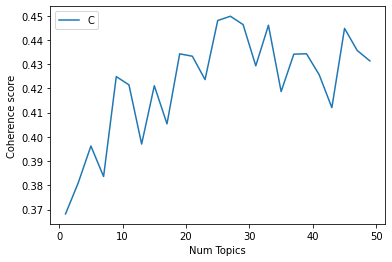

In [0]:
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("CoherenceValues"), loc='best')
plt.show()



In [0]:
PT=coherence_values[10:40]
print(PT)

[0.4332750280307153, 0.4236328816468449, 0.44802030316486385, 0.44978291303411927, 0.44634088062846433, 0.429319918870307, 0.4460681427669679, 0.4186950547923226, 0.43412491672705783, 0.43429377556348114, 0.42564912916368614, 0.4120648886741294, 0.44476755093570586, 0.4356379708402923, 0.4313397208436898]


In [0]:
Optimal_N_Topic=35#PT.index(max(PT))+10
print(Optimal_N_Topic)

35


### Run LDA with the optimal number of topics 

In [0]:
texts = words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

Optimal_lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=Optimal_N_Topic, 
                                       random_state=10,
                                       chunksize=100,
                                       passes=1,
                                       per_word_topics=True)

pprint(Optimal_lda_model.print_topics())
doc_lda = Optimal_lda_model[corpus]

2020-04-16 22:00:59,912 : INFO : using symmetric alpha at 0.02857142857142857
2020-04-16 22:00:59,913 : INFO : using symmetric eta at 0.02857142857142857
2020-04-16 22:00:59,917 : INFO : using serial LDA version on this node
2020-04-16 22:00:59,980 : INFO : running online (single-pass) LDA training, 35 topics, 1 passes over the supplied corpus of 915 documents, updating model once every 100 documents, evaluating perplexity every 915 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-16 22:00:59,982 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-04-16 22:00:59,983 : INFO : PROGRESS: pass 0, at document #100/915
2020-04-16 22:01:00,184 : INFO : merging changes from 100 documents into a model of 915 documents
2020-04-16 22:01:00,262 : INFO : topic #0 (0.029): 0.025*"canada" + 0.018*"covid" + 0.011*"government" + 0.010*"health" + 0.009*"march" + 0.008*"canadians" + 0.007*"order

[(34,
  '0.040*"bc" + 0.026*"pei" + 0.021*"covid" + 0.019*"health" + 0.014*"female" '
  '+ 0.011*"officer" + 0.011*"province" + 0.010*"sk" + 0.010*"march" + '
  '0.010*"www"'),
 (15,
  '0.032*"covid" + 0.019*"self" + 0.017*"ca" + 0.013*"information" + '
  '0.011*"essential" + 0.011*"www" + 0.010*"health" + 0.010*"visit" + '
  '0.009*"social_distancing" + 0.009*"individuals"'),
 (32,
  '0.043*"parking" + 0.040*"discontinue" + 0.029*"residential" + '
  '0.020*"permit" + 0.014*"enforced" + 0.014*"street" + 0.013*"effect" + '
  '0.013*"developments" + 0.012*"traffic" + 0.012*"route"'),
 (18,
  '0.099*"publichealth" + 0.057*"viruses" + 0.044*"misinformation" + '
  '0.032*"toll" + 0.024*"clinical" + 0.021*"cold" + 0.017*"world" + '
  '0.017*"cause" + 0.016*"chief" + 0.016*"organization"'),
 (6,
  '0.032*"workers" + 0.021*"said" + 0.021*"order" + 0.019*"health_care" + '
  '0.017*"health" + 0.017*"protection" + 0.016*"orders" + 0.015*"act" + '
  '0.014*"public_health" + 0.013*"emergency"'),
 (

## visualization
*pyLDAvis* is a python package to provide interactive web-based visualization to describe the topics that have been provided by the LDA model. 

In [0]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt



2020-04-16 22:01:02,996 : INFO : Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-04-16 22:01:03,027 : INFO : Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Optimal_lda_model, corpus, id2word)
vis

2020-04-16 22:01:04,374 : INFO : NumExpr defaulting to 2 threads.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.239217  0.032482       1        1  12.192582
28     0.273032  0.097432       2        1  10.641725
19     0.182919 -0.065437       3        1   9.616761
4      0.124805 -0.177219       4        1   6.715263
24     0.255852  0.164144       5        1   6.371092
10     0.239671  0.064367       6        1   5.744044
20     0.083956 -0.068238       7        1   5.131843
22     0.184571 -0.008787       8        1   4.666747
33     0.066263 -0.198281       9        1   4.627804
13     0.086846 -0.122232      10        1   2.971348
5      0.136665  0.119912      11        1   2.810370
6      0.082537 -0.000129      12        1   2.769715
34     0.031256  0.013252      13        1   2.729810
29     0.043151 -0.028232      14        1   2.606520
25    -0.017760 -0.185555      15        1   2.318649
27    -0.059324 -0.125559      16        1   2.146767
3      0.036442  0.051376      17        1   1.807747
26    -0.135127  0.112116      18        1   1.741524
9     -0.072035 -0.031177      19        1   1.248990
11    -0.057219 -0.022227      20        1   1.223887
14    -0.065682  0.030336      21        1   1.153584
16    -0.112722  0.019261      22        1   0.989181
18    -0.028760  0.107916      23        1   0.784708
7     -0.083034 -0.113843      24        1   0.745728
17    -0.100771  0.027929      25        1   0.721800
32    -0.127183 -0.077863      26        1   0.675055
23    -0.055925  0.030651      27        1   0.625940
8     -0.153303  0.051438      28        1   0.609279
1     -0.175212  0.040483      29        1   0.600811
0     -0.093481  0.052866      30        1   0.597842
30    -0.188522  0.050578      31        1   0.578626
31    -0.011472  0.041492      32        1   0.517920
12    -0.195922  0.084091      33        1   0.466575
21    -0.193158 -0.005277      34        1   0.427261
2     -0.140571  0.037936      35        1   0.422504, topic_info=          Term        Freq        Total Category  logprob  loglift
932   students  353.000000   353.000000  Default  30.0000  30.0000
1901    tested  361.000000   361.000000  Default  29.0000  29.0000
1257      said  743.000000   743.000000  Default  28.0000  28.0000
1385      toll  381.000000   381.000000  Default  27.0000  27.0000
1231     order  369.000000   369.000000  Default  26.0000  26.0000
...        ...         ...          ...      ...      ...      ...
519   accurate    4.997274   109.652512  Topic35  -5.1853   2.3783
158      march    7.367181  1029.207520  Topic35  -4.7972   0.5272
999       next    4.842504   117.595505  Topic35  -5.2168   2.2769
377         go    4.298768    96.617180  Topic35  -5.3359   2.3543
64       covid    3.462793  3659.348877  Topic35  -5.5521  -1.4962

[2025 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3695       8  0.949030  abundance
10419      1  0.064922         ac
10419      2  0.108204         ac
10419      3  0.021641         ac
10419      4  0.021641         ac
...      ...       ...        ...
518       24  0.604554       zero
2291      28  0.986528       zone
4493      21  0.134713      zones
4493      22  0.134713      zones
4493      26  0.673567      zones

[7708 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 29, 20, 5, 25, 11, 21, 23, 34, 14, 6, 7, 35, 30, 26, 28, 4, 27, 10, 12, 15, 17, 19, 8, 18, 33, 24, 9, 2, 1, 31, 32, 13, 22, 3])

# Run Search

In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


In [0]:
topics = Optimal_lda_model.print_topics(num_topics=Optimal_N_Topic, num_words=20)
topics = [topic[1] for topic in topics]
topics = [topic.split('"') for topic in topics]
search_inputs = [" ".join(topic_keys[1::2]) for topic_keys in topics]
search_inputs = [''.join([i if ord(i) < 128 else ' ' for i in text]) for text in search_inputs]

2020-04-16 22:01:19,022 : INFO : topic #0 (0.029): 0.070*"order" + 0.042*"underlying" + 0.039*"act" + 0.019*"comply" + 0.016*"html" + 0.016*"failure" + 0.012*"delay" + 0.012*"fine" + 0.011*"measures" + 0.011*"march" + 0.010*"greatest" + 0.010*"health" + 0.009*"reconsideration" + 0.009*"licences" + 0.009*"officer" + 0.008*"lightly" + 0.008*"patrons" + 0.007*"public_health" + 0.007*"believes" + 0.007*"covid"
2020-04-16 22:01:19,023 : INFO : topic #1 (0.029): 0.051*"technical" + 0.034*"rows" + 0.028*"michigan" + 0.019*"inspector" + 0.016*"indefinitely" + 0.014*"house" + 0.013*"experienced" + 0.013*"leisure" + 0.010*"chief" + 0.010*"steven" + 0.010*"tuesday" + 0.008*"dennis" + 0.007*"covid" + 0.007*"leader" + 0.006*"opposition" + 0.006*"led" + 0.006*"worked" + 0.006*"government" + 0.005*"essex" + 0.005*"said"
2020-04-16 22:01:19,025 : INFO : topic #2 (0.029): 0.035*"shall" + 0.030*"king" + 0.023*"pm" + 0.017*"proceeding" + 0.015*"determination" + 0.014*"wish" + 0.013*"commission" + 0.013*"

In [0]:
results_lda_df = search(search_inputs)


Search term:  order underlying act comply html failure delay fine measures march greatest health reconsideration licences officer lightly patrons public_health believes covid
  hits: 10
  mean score: 10.32829999923706

 1 ihxy08c7 11.55010 Street-level diplomacy and local enforcement for meat safety in northern Tanzania: knowledge, pragmatism and trust 10.1186/s12889-019-7067-8
 2 rvxkt60m 11.19920 The effect of control strategies to reduce social mixing on outcomes of the COVID-19 epidemic in Wuhan, China: a modelling study 10.1016/s2468-2667(20)30073-6
 3 19wkwldb 10.67790 La surveillance des personnes contacts pour Ébola : effets sociaux et enjeux éthiques au Sénégal 10.1007/s13149-016-0477-2
 4 mia3dytz 10.20300 Use of quarantine in the control of SARS in Singapore 10.1016/j.ajic.2004.08.007
 5 11hi1jel 10.12800 Estimating excess 1- year mortality from COVID-19 according to underlying conditions and age in England: a rapid analysis using NHS health records in 3.8 million adults 10

In [0]:
results_lda_df

,search,rank,title,score
0,order underlying act comply html failure delay...,1,Street-level diplomacy and local enforcement f...,11.5501
0,order underlying act comply html failure delay...,2,The effect of control strategies to reduce soc...,11.1992
0,order underlying act comply html failure delay...,3,La surveillance des personnes contacts pour Éb...,10.6779
0,order underlying act comply html failure delay...,4,Use of quarantine in the control of SARS in Si...,10.2030
0,order underlying act comply html failure delay...,5,Estimating excess 1- year mortality from COVID...,10.1280
...,...,...,...,...
0,bc pei covid health female officer province sk...,6,"COVID-19 clinical characteristics, and sex-spe...",13.4286
0,bc pei covid health female officer province sk...,7,Clinical Characteristics of Hospitalized Patie...,13.0332
0,bc pei covid health female officer province sk...,8,The direction of restructuring of a Korea fiel...,12.8782
0,bc pei covid health female officer province sk...,9,Preliminary epidemiological analysis on childr...,12.5018


# Comparison of Search Results


In [0]:
print("# Results using Oxford Labels as search inputs:", results_df.shape[0])

# Results using Oxford Labels as search inputs: 70


In [0]:
print("# Results using LDA topic-generated words as search inputs:", results_lda_df.shape[0])

# Results using LDA topic-generated words as search inputs: 350


In [0]:
len(np.unique(label_docids))

244

In [0]:
len(np.unique(lda2_docids))

152

In [0]:
common_results = np.intersect1d(np.unique(label_docids), np.unique(lda2_docids))
print("results in common: ", len(common_results))
common_results

results in common:  11


array(['An emergency medical services transfer authorization center in response to the Toronto severe acute respiratory syndrome outbreak',
       'Characterizing occupations that cannot work from home: a means to identify susceptible worker groups during the COVID-19 pandemic',
       'Coronavirus cancels chemical events',
       'Covid-19: What’s the current advice for UK doctors?',
       'Employment and Compliance with Pandemic Influenza Mitigation Recommendations',
       'Evaluating COVID-19 Public Health Messaging in Italy: Self-Reported Compliance and Growing Mental Health Concerns',
       'Protecting Home Health Care Workers: A Challenge to Pandemic Influenza Preparedness Planning',
       'Self-reported anticipated compliance with physician advice to stay home during pandemic (H1N1) 2009: Results from the 2009 Queensland Social Survey',
       'Suspending Classes Without Stopping Learning: China’s Education Emergency Management Policy in the COVID-19 Outbreak',
       'Syste

## New Research Discovered through Context-aware search

The below results were all additional discoveries through the addition of NPI-context to the document search process that were not found with the baseline method.

In [0]:
lda2_docids[:5]

['Street-level diplomacy and local enforcement for meat safety in northern Tanzania: knowledge, pragmatism and trust',
 'The effect of control strategies to reduce social mixing on outcomes of the COVID-19 epidemic in Wuhan, China: a modelling study',
 'La surveillance des personnes contacts pour Ébola : effets sociaux et enjeux éthiques au Sénégal',
 'Use of quarantine in the control of SARS in Singapore',
 'Estimating excess 1- year mortality from COVID-19 according to underlying conditions and age in England: a rapid analysis using NHS health records in 3.8 million adults']

In [0]:
results_lda_df['title']

In [0]:
print("Baseline average score: ", results_df['score'].mean())
print("NPI-Context average score: ", results_lda_df['score'].mean())

Baseline average score:  6.656889976773943
NPI-Context average score:  13.914187697001866


In [0]:
new_results = results_lda_df[~results_lda_df['title'].isin(results_df['title'].unique())]

print("Baseline # results: ", results_df.shape[0])
print("NPI-Context results: ", results_lda_df.shape[0])
print("New results above baseline: ", new_results.shape[0])

Baseline # results:  70
NPI-Context results:  350
New results above baseline:  339


In [0]:
new_results.sample(4)

,search,rank,title,score
0,behind customers bus west hsr service darts ex...,3,Impacts of high-speed rail on domestic air tra...,24.104500
0,employees alternatively suspect provided respi...,1,Covid-19: What’s the current advice for UK doc...,23.702900
0,bc pei covid health female officer province sk...,4,Epidemiological characteristics of novel coron...,13.996100
0,students school schools education educational ...,10,Effectiveness of Non-pharmaceutical Interventi...,23.431299
